[View in Colaboratory](https://colab.research.google.com/github/huang-E/Multi-class-Logistic-Regression/blob/master/Build_a_multi_class_classifier_from_scrach.ipynb)

## Build a  multi class  classifier to classify apps from the Apps Market into a set of categories based on their descriptions


## Data set description
The dataset is collected from the Apps Market. There are four main ﬁles:



1. training_data.csv:
●	There are 20,104 rows; each row corresponds to an app. 
●	For each row, each column is separated by comma (,). The ﬁrst column is the app’s name, with the remaining columns containing the tf-idf values. The tf-idf values are extracted from words in the description of each app.  pre-processing steps is done which resulted in 13,626 unique words. If a word is found in the description of an app, it has a tf-idf value (the tf-idf value is not zero). On the other hand, its tf-idf value is equal to zero if the word is not found in the description of the app. More information about tf-idf could be found in http://en.wikipedia.org/wiki/Tf%E2%80%93idf
●	In summary, data train.txt is a matrix with dimension: 20,104×13,627 (remember the ﬁrst column is the app’s name). 274158248

2. training_desc.csv: 
●	There are 20,104 rows; each row is for an app. 
●	For each row, each column is separated by comma (,). The ﬁrst column is the app’s name and the second column contains the app’s description.

3. training_labels.csv: 
●	There are 20,104 rows; each row is for an app. 
●	For each row, each column is separated by comma (,). The ﬁrst column is the app’s name and the second column is for the label.
●	There are 30 unique labels in total, for example Casual, Health and Fitness, etc.

Note that it is not necessary that the same rows of two training ﬁles refer to the same app. Please use the app’s name as a reference.

4. test_data.csv: 
●	This is a subset of the original data set; we have split the original data set into 90% for training set and 10% for test set (per label). This ﬁle should NOT be used for training the classiﬁer. 
●	Your code must be able to read the test set, and output a ﬁle “predicted_labels.csv” in the same data-format as “training_labels.csv”. Make sure the predictions (classiﬁcation results for the test set) are in the same order as test inputs, i.e. the ﬁrst row of “predicted_labels.csv” corresponds to the ﬁrst row of “test_data.csv” and so on). 
●	The score will be based on how accurate your approach is. We will collect “predicted_labels.csv” and compare it to the actual labels to get the accuracy of your approach. For further testing purposes, we may use a diﬀerent test set while grading.




---



## Authenticate and create PyDrive client.

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html


## Import data


In [0]:
import pandas as pd
import io
import numpy as np
from scipy import optimize
import matplotlib.pyplot as pl
%matplotlib inline 

In [3]:

# file_list = drive.ListFile({'q': "'< Data folder id >' in parents and trashed=false"}).GetList()
# https://drive.google.com/drive/folders/1humyKeBeYZWCrNiHNeeR8rQSLRj_2Qut?usp=sharing
file_list = drive.ListFile({'q': "'1humyKeBeYZWCrNiHNeeR8rQSLRj_2Qut' in parents and trashed=false"}).GetList()


for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
  
data_list = drive.ListFile({'q': "'1M7MIROIHoyBuRg5OMvpnXpqeKlKRzxGV' in parents and trashed=false"}).GetList()


for data1 in data_list:
  print('title: %s, id: %s' % (data1['title'], data1['id']))


title: Assignment_1.ipynb, id: 1EsLdaJNy5qEDYccyudJn3BBA1Ix3PmRC
title: .git, id: 1Z0hZ4Z23yITfCIV-0qvwUmBCug2UOCPB
title: .gitattributes, id: 174b1vsRX8C9TN5d76JGt2xOfWuWPrUOx
title: predicted_labels.csv, id: 1nCK9Z1VnAPUc4dGv1cGz23TzmSxigqN_
title: .ipynb_checkpoints, id: 1B2ERatG5vFKvWHoAqHUs5fjUDdCC93bN


### Pulling data into Google Colab.

In [0]:
training_data_downloaded = drive.CreateFile({'id': '1g69BfWiNwthqQZ-NgJU0-xi9--b4Sta6'})
training_data_downloaded.GetContentFile('training_data.csv')

training_desc_downloaded = drive.CreateFile({'id': '1tDH0vk9P79lnG0yL12YZW0EqV4spRQcs'})
training_desc_downloaded.GetContentFile('training_desc.csv')

training_labels_downloaded = drive.CreateFile({'id': '1MHAY1tSnLFNv9lVixTEtjtPLzeJwFs4s'})
training_labels_downloaded.GetContentFile('training_labels.csv')

test_data_downloaded = drive.CreateFile({'id': '1ZNRsjn8LyrnTJCXhLS5zzn2mETlXst3D'})
test_data_downloaded.GetContentFile('test_data.csv') 





### Load data files


In [0]:


training_data_df = pd.read_csv("training_data.csv",header=None,index_col = 0)
training_label_df=pd.read_csv("training_labels.csv",header=None,index_col = 0)
training_desc_df=pd.read_csv("training_desc.csv",header=None,index_col = 0)


In [0]:
### delete the objects release memory
del test_data_downloaded 
del training_data_downloaded
del training_labels_downloaded

In [0]:
training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20104 entries, com.borderstylo.retrollect to com.otakumode.otakucamera
Columns: 13626 entries, 1 to 13626
dtypes: float64(13624), int64(2)
memory usage: 2.0+ GB


In [0]:
#reduce file size
training_data_df=training_data_df.astype(np.float16)

In [0]:
training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20104 entries, com.borderstylo.retrollect to com.otakumode.otakucamera
Columns: 13626 entries, 1 to 13626
dtypes: float16(13626)
memory usage: 522.6+ MB




---


## A. Introduction

1- What is the aim of the study?


The aim of the study is to build and evaluate a classifier that uses the description of apps from the Apps Market to accurately predict a category for each app.




2- Why is this study important?

This study is important because app categories are a pivotal strategy in mobile marketing. For users, app categories assist in finding apps that best align with their needs. For app developers, selecting the right category for an app increases both the quantity and quality of traffic, ultimately expanding sales and customers. However, the numerous category options--33 categories in Google PlayStore [5] and 24 in the Apple [6] Store--pose a challenge in choosing the best category that describes the app. Therefore, there is a need to build a classifier that will objectively produce a category of an app that accurately mirrors the function of the app as detailed in its description. Given the voluminous number of applications available in the Apps Market and those still under development, it is also important to build an accurate classifier that is efficient in terms of running time.



## B. Methods 

**Environment** The code is running under colab without GPU, below shows the summary of the working environment

In [0]:
#CPU info
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc eagerfpu pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch kaiser fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms rtm rdseed adx smap xsaveopt
bugs		:
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
micro

In [0]:
#RAM info
!cat /proc/meminfo

MemTotal:       13341832 kB
MemFree:         1095244 kB
MemAvailable:   12631432 kB
Buffers:          136220 kB
Cached:         11045716 kB
SwapCached:            0 kB
Active:          1830484 kB
Inactive:        9722788 kB
Active(anon):     371708 kB
Inactive(anon):      284 kB
Active(file):    1458776 kB
Inactive(file):  9722504 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               328 kB
Writeback:             0 kB
AnonPages:        371408 kB
Mapped:           157268 kB
Shmem:               664 kB
Slab:             632896 kB
SReclaimable:     608324 kB
SUnreclaim:        24572 kB
KernelStack:        3248 kB
PageTables:         5240 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6670916 kB
Committed_AS:    1462140 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:      2048 kB
HugePages_Total: 

### Pre-processing


##### Creating working data frame
Frist step of the data pre-processing is to create a working data frame.
“Training_data” and “Training_label” data frames are joined by their index as new working data frame.  One reason behind this method is the sequence of the index for these two data frames are different




In [0]:
#### dataframe rename for columns "1":
training_label_df.rename(columns={1: 'labels'}, inplace=True)
training_desc_df.rename(columns={1: 'description'},inplace=True)
### Join columns with other DataFrame  on index to, the sequence are different for labels and data
# tmp = training_data_df.join(training_label_df)
# working_training_data_df = tmp.set_index('labels')
working_training_data_df=training_data_df.join(training_label_df)
# use inplace aovid memeory issue
working_training_data_df.set_index('labels',inplace=True)
# ### join description and labels dataframe
# description_labels_df=training_label_df.join(training_desc_df)

In [0]:
# removing trainin_data_df release memory
del training_data_df


In [0]:
working_training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20104 entries, Photography to Photography
Columns: 13626 entries, 1 to 13626
dtypes: float16(13626)
memory usage: 522.6+ MB


In [0]:
# Top 3 rows of the dataframe after processing
working_training_data_df.head(3)

,1,2,3,4,5,6,7,8,9,10,...,13617,13618,13619,13620,13621,13622,13623,13624,13625,13626
labels,,,,,,,,,,,,,,,,,,,,,
Photography,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Social,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Libraries and Demo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
working_training_data_df.shape

(20104, 13626)

#####  Sparsity  check for the data frame

The new working training data frame with dimension: 20,104×13626, but most of the data are zero due to TF-IDF nature, 99.5% of the data are zero.


In [0]:
count_nonzero_element = np.count_nonzero(working_training_data_df)
total_elements= working_training_data_df.size
sparsity =  1 - count_nonzero_element/float(total_elements)
print("The sparcity of the training dataframe is {:0.3f}".format(sparsity))
print("The size of the data is {}".format(working_training_data_df.shape))

The sparcity of the training dataframe is 0.995
The size of the data is (20104, 13626)


#### Dimensionality Reduction and Feature selection

Due to the large number of features, the computation will become expensive when we later train our classifier. Dimensionality reduction is required. 

**Runtime 362 seconds**

###### Information gain method used to select the top N features
As per [1], An information gain method is used to rank each feature’s importance in terms of information gain, the more the value of information gain for a feature, the more discriminatory power the feature is.  The $P_i$ is the global probability of class $i$, and $p_i(w)$ is the probability of class $i$, given that the document contains the word $w$. $F(w)$ is the fraction of the documents containing the word $w$. The information gain measures $I(w)$ for a given word w is defined as the formula. The time complexity is $O(n.d.k)$, where $n$ is the number of documents, $d$ is the number of words, $k$ is the number of class. So in our case the time complexity is $O(20104*13626*30)$
                      \begin{equation}
\begin{split}
I(w) & = -\sum_{i=1}^{k}P_ilog(P_i) + F(w)\sum_{i=1}^{k}p_i(w)log(p_i(w)) + \\
& (1 - F(w))\sum_{i=1}^{k}(1-p_i(w))log(1-p_i(w))
\end{split}
\end{equation}


From above steps and compare with SVD analysis, the conclusion is we can keep top 3000 features while remaining the majority of the information

Selecting 3000 features proved to be correct will be demonstrated in the later stage, it shows the features number increased to 3000, there is not much gain in terms of the performance.


In [0]:
##Preparation for caculating infogain############
from collections import Counter
class_counts=(Counter(working_training_data_df.index.values))
total_samples = len(working_training_data_df )
class_list=list(class_counts.keys())
### caculate the constant the global probability of class i and its entropy
### 30 classes entropy
total_entropy = 0
for k in class_counts.keys():
    P_i=(class_counts[k])/float(total_samples)
    total_entropy = total_entropy + P_i*np.log(P_i)


In [0]:
#####################################################
#Compute Info gain
####################################################
def infogain(train_df):
    I_w = {}
    rows,cols = train_df.shape
    ### the feature starts from 1
    for col in range(1,13627):
        ### starting from 1 to 13627 feature
        ## working on each col/feature to get each feature's infogain
        check_non_zero = train_df.loc[:,col]>0
        count_non_zero = sum(train_df.loc[:,col]>0)
        #### check all 30 classes and compute the probability/entropy for all
        entropy_1 = 0
        entropy_2 = 0
        for cls in class_list:
            check_cls = (train_df.index.values==cls)
            ### this gives the total number of counts meet both w and class condition
            check_counts = np.sum(check_non_zero & check_cls)
            p_i = check_counts/rows ## the probability of p_i
            if p_i !=0 and p_i !=1: #ignore the zerop probability avoid nan value
                entropy_1 = entropy_1 +p_i*np.log(p_i)
                entropy_2 = entropy_2 + (1-p_i)*np.log(1-p_i)
      
        f_w = count_non_zero/float(rows)
        i_w = -total_entropy + f_w*entropy_1 + (1-f_w)*entropy_2
        
        I_w[col]=i_w
    return I_w

In [0]:
### Cuculate the infogain result
import time
start_time = time.time()
infogain_result=infogain(working_training_data_df)
print("--- %s seconds ---" % (time.time() - start_time))
infogain_df=pd.DataFrame.from_dict(infogain_result,orient='index')
infogain_df.head(5)

--- 361.96477580070496 seconds ---


,0
1,3.388888
2,3.389039
3,3.387017
4,3.388989
5,3.388989


In [0]:
### selecting top 3000 features
n=3000
n_feature_selected=infogain_df.sort_values(by=[0],ascending=True).head(n)
new_feature_list=n_feature_selected.index.values

In [0]:
from psutil import *
virtual_memory()

svmem(total=13662035968, available=5711126528, percent=58.2, used=7690735616, free=194080768, active=9255727104, inactive=3564474368, buffers=133787648, cached=5643431936, shared=679936, slab=569405440)

#### Result of preprocessing include:
* A **reduced** size working dataframe with 3000 features reduced from 13626

* A **new_feature_list** containing the 3000 features name, which will be used to reduce dimension for testing data when predicting testing data label

In [0]:
working_training_data_df_reduced = working_training_data_df.loc[:,new_feature_list]
working_training_data_df_reduced.head(3)

,1775,570,12701,4146,13264,4498,461,4774,12077,592,...,11603,8692,10093,3069,3423,9313,763,12007,5682,7126
labels,,,,,,,,,,,,,,,,,,,,,
Photography,0.057404,0.019791,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Social,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Libraries and Demo,0.000000,0.022934,0.026047,0.0,0.0,0.0,0.041199,0.041748,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from psutil import *
virtual_memory()

svmem(total=13662035968, available=5716385792, percent=58.2, used=7685480448, free=188248064, active=9264971776, inactive=3565428736, buffers=137707520, cached=5650599936, shared=679936, slab=569315328)

### Classifier

Logistic regression algorithm is chosen as the classifier.
The objective is to learn a function that approximate $P(Y/X)$. The assumption is $P(Y/X)$ is a sigmoid function applied to linear combination of input features\begin{equation} \begin{aligned}\mathbb{P}(y=1|z) &=\sigma(z)=\frac{1}{1+e^{-z}}\\\end{aligned}\end{equation}

$z$ is linear combination of the parameter $w$ and input $X$
\begin{equation}
{ z_i =  \mathbf{x}_i \cdot \mathbf{w}_i } = w_0 + x_{i1} w_1 + x_{i2} w_2 + \cdots + x_{i(D+1)} w_{i(D+1)}
\end{equation}
for $i={1,...,N}$


There are 30 labels to be predicted in this problem, the problem become a multi class classification problem

In multi class problem, one vs rest method is used. This issue becomes 30 binary classification problems. so, we need to train 30 classifiers.


There are a 3 parts build in for logistic classifier

##### Part 1 is the utility function 
These utility function used for transform the input ($X$, $y$) to required format due to interception

##### Part 2 the model training function
Part 2 part will return a learned $w$ matrix based on training data input ($X$,$y$) and $Regu$ 
* **sigm(z)** 
The sigmoid function work as a link function, the output will return a probability value between 0 and 1

\begin{equation} \begin{aligned}\sigma(z)=\frac{1}{1+e^{-z}}\\\end{aligned}\end{equation}

* **costfunctionJ(w,Regu,X,y)** Logistic Cost function with regularization is defined as

\begin{equation}
    J(\mathbf{w}) = \sum_{i=1}^{N} \bigg( -y_i log \big( p(\mathbf{x_i}) \big) +
          (1-y_i) \log \big( 1 - p(\mathbf{x_i}) \big)  \bigg) + \frac{\lambda}{2}| \mathbf{w} \|^2
\end{equation}

where $w$ is the parameters to learn, $Regu$ is the regularized hyper parameter from cross validation 0.5 is chosen to aovid overfitting. ($X$,$y$)is the training data

* **GD(w,Regu,X,y)** Gradient descent function is defined as

                             Repeat {

\begin{equation}
    \mathbf{w}_0 :=\mathbf{w}_0 - \alpha\frac{1}{m} \sum_{i=1}^{m} \big(h_w\big(\mathbf{x^{(i)}} \big) - y^{(i)}\big)\mathbf{x^{(i)}_0}
\end{equation}

\begin{equation}
    \mathbf{w}_j :=\mathbf{w}_j - \alpha\frac{1}{m} \sum_{i=1}^{m} \big(h_w\big(\mathbf{x^{(i)}} \big) - y^{(i)}\big)\mathbf{x^{(i)}_j} + \frac{\lambda}{m} \mathbf{w}_j \
\end{equation}

                                        }

The gradient descent evaluates and update the $w$ every iteration to minimize the error. 

* **classifier(X,y,Regu,classes,solver)** is function minimize the loss function and return the learned parameter $w$. The classifier function taking traing data ($X$,$y$), $regularizer$, $classes$ and $solver$,(different optimisation method available in SciPy). From cross validation result 'L-BFGS-B' is chosen as the method in terms of efficiency and effectiveness balance.


##### Part 3 the prediction function 
* **prediction(x_trainingdata,w_matrix)** is function to predict, the input is the learned $w$ from classifier function, and new test $X$, the output is the label, which shows the input belong to which category. The predicted class is chosen based on the highest probability out of all predicted result.

* **accu_test(predict_y,actual_y)** is function to test the prediction accuracy.


In [0]:
### get X, y  from reduced dataframe
X = working_training_data_df_reduced.values
y = working_training_data_df_reduced.index.values

## convert y to number
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y.ravel())
y=le.transform(y.ravel())

print("X shape is {} and y shape is {}".format(X.shape,y.shape))

X shape is (20104, 3000) and y shape is (20104,)


Building classifier

In [0]:
from scipy import optimize

############# utilitity function used to transform matrix due to constant###############
def extend_to_intercept(x):
    return np.hstack((np.ones((x.shape[0],1)), x))
#transformed to required format
def transform(X,y):
    transformed_X = extend_to_intercept(X)
    transformed_y = np.atleast_2d(y).T
    return transformed_X,transformed_y
####################################################################


#Sigmoid function
def sigm(z):
    return 1.0/(1.0+np.exp(-z))

## The costfunction with regularization
def costfunctionJ(w,Regu,X,y):
    z = np.dot(X,w)
    predictions = sigm(z) # prediction result
    m = X.shape[0] # number of sample
    # with out regularization
    J_1 =(-1/m)*(np.dot(np.log(predictions),y) + np.dot(np.log(1-predictions),(1-y)))
    #start from 1, regularization part
    J_2 = (np.sum(w**2)-w[0]**2)*Regu/(2*m)
    J = J_1 + J_2
    return J[0]

### Gradient descent
def GD(w,Regu,X,y):
    z = np.dot(X,w.reshape(-1,1))
    predictions = sigm(z)
    m = X.shape[0]
    jacob_gd = (1/m)*(np.dot(X.T,predictions-y)) + (Regu/m)*w.reshape(-1,1)
    jacob_gd[0] = jacob_gd[0] -(Regu/m)/m*w[0].reshape(-1,1)
    return jacob_gd.ravel()


def classifier(X,y,Regu,classes,solver):
    ######
    X,y = transform(X,y)
    #####
    weight_matrix = np.zeros((classes,X.shape[1])) # create numberofclasses*numberoffeature matrix 
    theta = np.zeros((X.shape[1],1)) # create number of parameters for theta
    print("building model...")
    for i in range(classes):
        
        res = optimize.minimize(costfunctionJ, theta, args=(Regu, X, (y == i)*1), method=solver,
                       jac=GD)
        weight_matrix[i] = res.x
    print("model built")
    return weight_matrix

def prediction(x_test,w_matrix):
    ####
    x_test = extend_to_intercept(x_test)
    ####
    predict=sigm(x_test.dot(w_matrix.T))
    y_hat = np.argmax(predict,axis=1) # return the result
    return y_hat

def accu_test(predict_y,actual_y):
    return np.sum(predict_y==actual_y)/float(len(predict_y))

## C. Experiments and Results

#### 10 fold cross validation accuracy

The 10-fold cross validation average mean accuracy for the model is 64%.
We selected 0.5 as regularised parameters to control overfitting and used 'L-BFGS-B' Limited-memory BFGS as the optimisation method. The reasons chosen these two number will be discussed in extensive study

**Runtime 1793 seconds**


In [0]:
Regu = 0.5 ## is a constant that determines the amount of smoothing, regularized parameter lambda 
classes = 30
solver = 'L-BFGS-B'

# --- 1793.6615533828735 seconds  ---
import time
start_time = time.time()
from sklearn.model_selection import KFold
k = 10
sum = 0
kf = KFold(n_splits=k)
result_k_fold =[]
for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    weight_matrix =  classifier(X_train,y_train,Regu,classes,solver)
    y_hat =  prediction(X_test,weight_matrix)
    result_k_fold.append(accu_test(y_hat,y_test))
    sum += accu_test(y_hat,y_test)
average = sum/k
print("--- %s seconds ---" % (time.time() - start_time))

building model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


model built
building model...
model built
building model...
model built
building model...
model built
building model...
model built
building model...
model built
building model...
model built
building model...
model built
building model...
model built
building model...
model built
--- 1793.6615533828735 seconds ---


In [0]:
Formatted_result_k_fold = [ '%.2f' % elem for elem in result_k_fold ]

In [0]:
print("The model accuracy for each fold is {}".format(Formatted_result_k_fold))
print("The model average accuracy is {}".format(round(average,2)))

The model accuracy for each fold is ['0.64', '0.63', '0.62', '0.64', '0.64', '0.64', '0.64', '0.64', '0.64', '0.64']
The model average accuracy is 0.64


#### precision, recall, F-measure

From 10-fold cross validation we can see the model achieved 64% accuracy for each fold. We will use previous trained model to estimate the performance.
The result shows top 3 performance classes are ** Cards and Casino,Medical,News and Magazines** , the F_measures for best performance classes ismore than 80%, while the bottom 3 performance classes are ** Lifestyle,	
Entertainment, Productivity ** their F_measure are less than 50%. 


In [0]:
score_metrics=pd.DataFrame(columns=['precision','recall','F_measure'])
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_hat,y_test)
### evaluate the conf confusion matrix
rows = 30
total_predicted_positive = np.sum(conf,axis=0) # for all 30 classes
total_actual_positive = np.sum(conf,axis=1) # for all 30 classes
TP_array = np.diag(conf) # list of true postive
# build dictionary for label code and name
class_dict={}

for i in range(30):
    class_dict[i]=le.inverse_transform(i)
for class_c in range(rows):
    TP = TP_array[class_c]
    precision = round(TP/total_predicted_positive[class_c],2)
    score_metrics.loc[class_c,"precision"]=precision
    recall = round(TP/total_actual_positive[class_c],2)
    score_metrics.loc[class_c,"recall"]=recall
    F_measure = round(2*recall*precision/(recall + precision),2)
    score_metrics.loc[class_c,"F_measure"]=F_measure
# change index name
score_metrics.rename(index=class_dict,inplace=True)
#sort by best F_measure
score_metrics.sort_values(by=['F_measure'],ascending=False)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

,precision,recall,F_measure
Cards and Casino,0.92,0.9,0.91
Medical,0.83,0.84,0.83
News and Magazines,0.82,0.85,0.83
Finance,0.88,0.77,0.82
Weather,0.77,0.85,0.81
Health and Fitness,0.77,0.81,0.79
Sports,0.76,0.81,0.78
Racing,0.74,0.81,0.77
Photography,0.85,0.68,0.76
Transportation,0.79,0.68,0.73


### Extensive Analysis



In this part, we looked at how to select optimisation method $solver$, the optimal hyper parameter $Regu$, and the optimal number of feature sizes
 
1.  5 optimisation methods evaluated and tested in SciPy minimize optimisation
need to select the one with effectiveness(accuracy) and efficiency (running time) balance

2. In order aovid overfitting of the model hyper parameter $Regu$ needs to be chosen carefully

3. The more feature included will cause more computation time, but not necessarily improve the performance, so choosing the least number of features while keep the performance is important



We used cross validation to find these  optimal values 

The extensive analysis show the optimal value for $solver$ is ** 'L-BFGS-B' **, $Regu$ **0.5**, number of feature is **3000**



#### 1. Chosing the optmisation method

** First get reduced size of data for faster computation **

In [0]:
### firstly get reduced size of the data 
### sort the infogain_df
n=500
n_feature_selected=infogain_df.sort_values(by=[0],ascending=True).head(n)
new_feature_list=n_feature_selected.index.values
## reduced dataframe
working_training_data_df_reduced = working_training_data_df.loc[:,new_feature_list]


### get X, y  from reduced dataframe
X = working_training_data_df_reduced.values
y = working_training_data_df_reduced.index.values

## convert y to number
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y.ravel())
y=le.transform(y.ravel())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=99)


In [0]:
# check memory usage
from psutil import *
virtual_memory()

svmem(total=13662035968, available=5706395648, percent=58.2, used=7695470592, free=173490176, active=9300389888, inactive=3544465408, buffers=147873792, cached=5645201408, shared=679936, slab=568967168)

We calculated each solver's accuracy and computation time, with reduced feature size(500), and fixed regularizer(0.5)
'L-BFGS-B' method is chosen due to its good accuracy and less time required. This is consistent with result finding in [2]

**Runtime 1300 Seconds**

In [0]:
# list of solver in Scipy
list_of_solver=['L-BFGS-B','BFGS', 'Newton-CG','CG', 'TNC']

Regu = 0.5 ## regularized parameter lambda to reduce overfitting 
classes = 30
result_method_n500 = []
for solver in list_of_solver:
    print("{} method starts".format(solver))
    start_time = time.time()
    weight_matrix = classifier(X_train,y_train,Regu,classes,solver)
    y_hat =  prediction(X_test,weight_matrix)
    result = accu_test(y_hat,y_test)
    elapsed_time = time.time() - start_time
    result_method_n500.append((solver,result,elapsed_time))

From the plot below we can see 'L-BFGS-B' is the optimal choice for optimisation

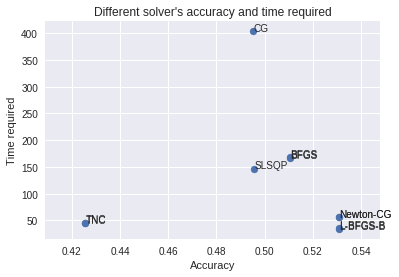

In [0]:

methods,accuracy_m,time_m = zip(*result_method_n500)
fig, ax = pl.subplots()
ax.scatter(accuracy_m, time_m)
for i, text in enumerate(methods):
    ax.annotate(text,(accuracy_m[i],time_m[i]))
pl.title("Different solver's accuracy and time required")
pl.xlabel('Accuracy')
pl.ylabel('Time required')
pl.show()

####  2. Finding the optimal hyper parameter $Regu$, using reduced feature size(500) and fixed method 'L-BFGS-B'

 **Runtiem 810seconds**


In [0]:
Regu = 0.05 ## is a constant that determines the amount of smoothing, regularized parameter lambda to reduce overfitting basis starts with 0.05 and increase
classes = 30
solver = 'L-BFGS-B'
result_with_regu =[]
for step in range(1,20):
    print("reguarlizer value {}".format(Regu*step))
    start_time = time.time()
    weight_matrix = classifier(X_train,y_train,Regu*step,classes,solver)
    y_hat =  prediction(X_test,weight_matrix)
    result = accu_test(y_hat,y_test)
    elapsed_time = time.time() - start_time
    result_with_regu.append((Regu*step,result,elapsed_time))

The accuracy is fluctuating when hyper parameter is between 0.3 to 0.6. 0.5 is selected as the optimal parameter

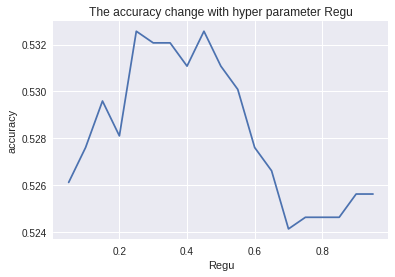

In [0]:
Regu,accuracy_m,time_m = zip(*result_with_regu)
fig, ax = pl.subplots()
ax.plot(Regu,accuracy_m)
pl.title("The accuracy change with hyper parameter Regu")
pl.xlabel('Regu')
pl.ylabel('accuracy')
pl.show()

#### 3. loop different size of sample to get the optimal number of feature size


In [0]:
accuracy_reslut = []

for i in range(1,20):
    n_feature_selected=infogain_df.sort_values(by=[0],ascending=True).head(i*500)
    new_feature_list=n_feature_selected.index.values
    working_training_data_df_reduced = working_training_data_df.loc[:,new_feature_list]
    ### get X, y  from reduced dataframe
    X = working_training_data_df_reduced.values
    y = working_training_data_df_reduced.index.values

    ## convert y to number
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(y.ravel())
    y=le.transform(y.ravel())

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=66)
    
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, predictions)
    accuracy_reslut.append((i*500,accuracy))


The accuracy did not improve much after 3000 features, so selected 3000 features

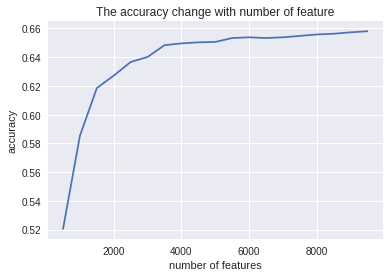

In [0]:
pl.plot(*zip(*accuracy_reslut))
pl.title("The accuracy change with number of feature")
pl.xlabel('number of features')
pl.ylabel('accuracy')
pl.show()


## D. Export Results 

This is important for your grading.


You must save a file named “**predicted_labels.csv**” in the **same data format** as “training_labels.csv”.

You can use PyDrive to save the data file (example is not provided here and you should find out how to do it on your own).

Make sure the predictions (classiﬁcation results for the test set) are in the **same order** as test inputs, i.e. the ﬁrst row of “predicted_labels.csv” corresponds to the ﬁrst row of “test_data.csv” and so on). 

Your score will be based on how accurate your approach is. We will collect “predicted_labels.csv” and compare it to the actual labels to get the accuracy of your approach. For further testing purposes, we may use a diﬀerent test set while grading.


**Insert the url address of your predicted_labels.csv file:   **

---[Predicted_labels.csv](http://s000.tinyupload.com/?file_id=08330322310879146471)





### **Following are just codes how to get the predicted lables no need to run**

##### Getting test data and submission result

In [0]:
### selecting top 3000 features
n=3000
n_feature_selected=infogain_df.sort_values(by=[0],ascending=True).head(n)
new_feature_list=n_feature_selected.index.values

testing_data_df = pd.read_csv("test_data.csv",header=None,index_col = 0)
### need to use the same featured used for trained model
testing_data_df_reduced = testing_data_df.loc[:,new_feature_list]
# create index list for construction dataframe
index_name=testing_data_df_reduced.index.values
X_testing = testing_data_df_reduced.values

(9500,)

#### training on my model

In [0]:
### train model remember to use all available training data, X shape should be
### (21034,3000)
Regu = 0.5 ## regularized parameter lambda to reduce overfitting 
classes = 30
solver = 'L-BFGS-B'
using_trainingdata_model = classifier(X,y,Regu,classes,solver)
# y_hat =  prediction(X_test,using_trainingdata_model)
# result_on_testdata = accu_test(y_hat,y_test)

building model...


C:\Users\hy\Anaconda3\envs\test_py3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


model built


#### Predict test data with my model

In [0]:
prediction_result_withmymodel = prediction(X_testing,using_trainingdata_model)

#### construct result for output

In [0]:
testing_data_result=pd.DataFrame(columns=['Appname','Predicted Category'])
rows= testing_data_df_reduced.shape[0]
for i in range(rows):
    testing_data_result=testing_data_result.append({'Appname':index_name[i],'Predicted Category':prediction_result_withmymodel[i]},ignore_index=True)
### update the Predicted Category column based on class_dict
testing_data_result=testing_data_result.replace({"Predicted Category":class_dict})
# set index as Appname
testing_data_result.set_index('Appname',inplace=True)

#### write result to csv

In [0]:
# writing result to csv, removing header having same format as provided data
testing_data_result.to_csv("predicted_labels.csv",header=False)

## E. Discussion


There was a challenge when dealing with large datasets, the memory for Colab is not suffcient. Worked out a few workaround to solve these issue, one of the workaround is to change the default datatype in pandas dataframe from float64 to float16, which saved about 1.5GB RAM


From the F_score measurement we noticed some classes are perform better than others, what the reasons behind it.
we investigate the description from two aspects
* One from the average description length
it was assumed the more information in the description will give better prediction result, the result is surprisingly showing the worst performance class "Entertainment" having more average description compared to the best performance class "Cards and Casino", so the length of the description is not the reason

* Second from the actual description. We looked at Cards and Casino and Entertainment's description in details. Cards and Casino are showing best F_measure, Entertainment are showing worst F_measure. From the contents we can see it is easier for user to classify the app to Cards and Casino when reading the description. Cards and Casino App having more discriminative description


In [0]:
### get the string length of each description
# ### join description and labels dataframe
description_labels_df=training_label_df.join(training_desc_df)
description_labels_df['desc_len']=description_labels_df['description'].apply(len)
description_labels_df.groupby(['labels'])['desc_len'].mean().sort_values().head(15)

labels
Libraries and Demo     632.417537
Comics                 780.986072
News and Magazines     806.721127
Lifestyle              868.909091
Sports Games           922.946759
Shopping               930.890733
Media and Video        946.895664
Social                 948.951791
Sports                 955.584541
Cards and Casino       975.285917
Transportation         993.660615
Racing                1037.958716
Entertainment         1039.455202
Weather               1053.526860
Brain and Puzzle      1054.477825
Name: desc_len, dtype: float64

In [0]:
#Example of the "Cards and Casino" best F_measure with shorter description
pd.set_option('display.max_colwidth', -1)
description_labels_df[description_labels_df['labels']=="Cards and Casino"].head(3)

,labels,description,desc_len
0,,,
com.infimosoft.videopoker,Cards and Casino,Simple and fast video poker game with the look and feel of a classic video poker machine like the ones you can find in a Las Vegas casino. Video Poker Machines: Jacks or Better Double Bonus Joker's Wild,202
air.biz.rightshift.clickfun.casino,Cards and Casino,Get ready for a whole new way to spin and win with the brand new version of Clickfun Casino! Enjoy the thrills of virtual casino action with Clickfun Casino for FREE on your mobile device. Install the app now and join our community of millions of players in one of Facebook’s fastest growing social casinos. It’s Vegas on your phone. And a slots experience second to none wherever you are whenever you like. Download our app and start cashing in on: • Free coins available every day and every hour! • Level-up achievements that unlock more pay lines bigger instant wins and extra game features. • Free spins and regular giveaways are yours for the taking. • Give gifts share successes and be part of the friendliest slots community online. • Multiply the rewards of winning by sharing the fun with friends! • Sensational slots graphics and high quality realistic sound effects. • Easy to play slots fun that gives you true-to-life gaming excitement. You’ll feel like you’re right inside a real casino! ★☆ Totally Free Play ★☆ Come in for a spin and stay to play! It’s totally 100% no-small-print FREE. ★☆ Get Social ★☆ Challenge your friends and beat your rivals as you play for free. Watch the reels line up for big wins and even bigger brags as you earn your way up the ranks and hear the coins roll in. Get ahead with the app by collecting your daily free chips on the go. Accumulate as many as you can as you aim for total slots domination! Share gifts and enjoy tournament-style gaming where your personal slots strategy and dedication to winning will put you ahead of the pack. ★☆ Newcomers always welcome! ★☆ Even if you’re only starting out you’ll have an immediate advantage. Newcomers get a fat virtual bankroll that’ll give you the boost you need to sample the social features and work your way up to taking on the champs! ★☆ The Clickfun Game Selection ★☆ Don’t settle for playing the same old slots. You deserve the best of the best. Loads of hot slot games are all yours for the taking and we never stop dreaming up more ways for you to play and win in the Clickfun lab. Supported Devices: Our app runs on all devices running Android 2.2 (Froyo) and above with 768MB of memory or more. Things You Need To Know: • The app currently includes the following games: Alley Cats Kings and Queens Snow Honeys Stash of the Titans Lucky Shot The Grand Circus Gypsy Queen Reel Baron Polar Bash Mardi Gras Fever Double O' Cash Bomber Girls Lucky News Network and Kung Fu Monkey. Many more are coming soon! • Our Terms of Use and Privacy Policy can be viewed in full at http://m.clickfun.com/terms and http://m.clickfun.com/privacy • If you have any problems with the app or need any help along the way contact our support team at http://m.clickfun.com/contact Happy gaming!,2797
com.gamblekings.casinoslotsm,Cards and Casino,Hot casino king fever Vegas Style with free coins to feed your Free Slot Machines Multiple Reels crave! Made for free lucky Grand Casino apps fans. Enjoy the best casino style multiple reels free slots machines fun with a twisted flavour that will bring you hours of entertainment and have a crush on our apps! + Free unlimited credits or coins after using your 3000 you get bonus 3000 every time! Bonus bonus bonus! + No money involved at all all coins are free so you can bet without worrying and enjoy slot machines multiple reels for free + Perfect small free slots games android app under 5MB in size with multiple reels (5) + Spin the multiple reels and win for free constantly to keep the fun going! + Multiple themes across our slots machines to chose from for lucky 7 charms + Vegas sounds so you get the action feel of a real l

In [0]:
#Example of the "Entertainment " poor F_measure, with longer description
pd.set_option('display.max_colwidth', -1)
description_labels_df[description_labels_df['labels']=="Entertainment"].head(3)

,labels,description,desc_len
0,,,
com.andser.software.spraycans,Entertainment,Finally you can paint walls with a spray. Create your customized graffiti! Set your color choose your cap and go! Save share your creations or set as wallpapers! Naturally don't forget to shake your spray can to refill! ***Features: 20 different backgrounds. 5 different spray-sizes Paint leaks effect undo - redo option save share and set as wallpaper option shake feature! sounds on/off new: now you can insert stars to your creation! Have fun!! Follow AndserLab on Twitter and Facebook!,494
com.coresense.iFangsLite,Entertainment,Updated with 4 fangs and Galaxy S3 support! Make your friends laugh with iFangs Lite ! Check out the paid version of iFangs for the full suite of fangs. Scare your parents put them on your dog or use them in your next family portrait. With iFangs Lite your imagination is the limit! iFangs will seamlessly loop until you're done scaring your friends. To go back to the main menu simply shake your device.,411
com.zoomart.Maze_Scary_Horror,Entertainment,With this application you can scare your friends. How to play? 1 - Select the monster you want horrible scare. 2 - Use the joystick on the screen of your mobile to control the red ball through the maze. 3 - While progress through the maze there will come a time when the character suddenly appears you chose a terrible cry and your friends remain terrified. ✔ Several horrific monsters to scare ✔ Great picture quality ✔ Great sound quality ✔ HD-ready tables ✔ It's free!,473


## F. Conclusion and future work 



We looked at our model from **effectiveness** and **efficiency** perspective compared to Sklearn Logistic regression
* **effectiveness**: The model developed in this assignment overall showing similar accuracy compared to Sklearn Logistic Regression.
* **efficiency** The time spent to train the model is not as efficient as Sklearn Logistic Regression, our model need 8 times more to train the model. This is the area need to look at how to improve the efficiency of our algorithm. This is likely due to training 30 classifier without using multi processing


In [0]:
n=3000
n_feature_selected=infogain_df.sort_values(by=[0],ascending=True).head(n)
new_feature_list=n_feature_selected.index.values
## reduced dataframe
working_training_data_df_reduced = working_training_data_df.loc[:,new_feature_list]


### get X, y  from reduced dataframe
X = working_training_data_df_reduced.values
y = working_training_data_df_reduced.index.values

## convert y to number
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y.ravel())
y=le.transform(y.ravel())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=99)

In [0]:
import time
from sklearn.linear_model import LogisticRegression
start_time = time.time()
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
result_on_logistic = round(accu_test(predictions,y_test),2)
elapsed_time = round((time.time() - start_time),2)
print("Sklearn logistic model accuracy is {}, time is {} seconds".format(result_on_logistic,elapsed_time))

Sklearn logistic model accuracy is 0.65, time is 16.8 seconds


In [0]:
Regu = 0.5 ## regularized parameter lambda to reduce overfitting 
classes = 30
solver = 'L-BFGS-B'
import time
start_time = time.time()
using_trainingdata_model = classifier(X_train,y_train,Regu,classes,solver)
y_hat =  prediction(X_test,using_trainingdata_model)
result_on_mylogistic = round(accu_test(y_hat,y_test),2)
elapsed_time = round((time.time() - start_time),2)
print("Our logistic model accuracy is {}, time is {} seconds".format(result_on_mylogistic,elapsed_time))

building model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


model built
Our logistic model accuracy is 0.65, time is 163.77 seconds


## G. References

*You should provide appropriate citations throughout your report and list your references here.*

list of references

1.  Aggarwal C.C., Zhai C. (2012) A Survey of Text Classification Algorithms. In: Aggarwal C., Zhai C. (eds) Mining Text Data. Springer, Boston, MA
2.  Minka, Thomas P. "A comparison of numerical optimizers for logistic regression." Unpublished draft (2003).  
3. Zhu H., Chen E., Xiong H., Cao H. and Tian J. (2014) 'Mobile App Classification with Enriched Contextual Information', IEEE Transactions on Mobile Computing, vol. 13, no. 7, pp. 1550-1563, accessed 30 April 2018, http://ieeexplore.ieee.org/abstract/document/6585246/
4. Rank My App, We need to talk about the app category, accessed 30 April 2018, https://www.rankmyapp.com/market/we-need-to-talk-about-the-app-category/
5. Statista 2018, Most popular Google Play app categories as of 1st quarter 2018, by share of available apps, accessed 02 May 2018, https://www.statista.com/statistics/279286/google-play-android-app-categories/
6. Apple Inc 2018, Choosing a Category, accessed 02 May 2018, https://developer.apple.com/app-store/categories/
7. A Limited Memory Algorithm for Bound Constrained Optimization Richard H. Byrd, Peihuang Lu, Jorge Nocedal, and Ciyou Zhu
